This notebook is just to calculate the MILB using the new ensembles built with `FlowEnsemble`, which were trained with error convolution.
This probably could have been done in one of the existing notebooks, but they are messy and confused me, so I will do this here for now and we can port these results over later.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from pzflow import FlowEnsemble

Load the Catalogs:

In [2]:
# list of available catalogs
available_os = ["run_1_4_y10", "run_4_38_y10", "run_10_92_y10", "run_4_34_y10", "run_7_61_y10", "run_9_86_y10"]
names = [
    "baseline_v1_5_10yrs",
    "footprint_stuck_rollingv1_5_10yrs",
    "ddf_heavy_nexp2_v1_6_10yrs",
    "footprint_newAv1_5_10yrs",
    "third_obs_pt60v1_5_10yrs",
    "barebones_v1_6_10yrs",
]
os_names = dict(zip(available_os, names))
colors = ["k", "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]
os_colors = dict(zip(available_os, colors))

In [3]:
# column names of the catalogs
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=(
    'ID', 'z_true', 
    'u', 'u_err',
    'g', 'g_err',
    'r', 'r_err',
    'i', 'i_err',
    'z', 'z_err',
    'y', 'y_err',
    'u-g', 'u-g_err',
    'g-r', 'g-r_err',
    'r-i', 'r-i_err',
    'i-z', 'i-z_err',
    'z-y', 'z-y_err',
)

# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

Load the saved ensembles

In [4]:
ensembles = {}
for os in available_os:
    ensembles[os] = FlowEnsemble(file=f"trained_flows/pzflow_ensemble_for_{os}.pkl")

Calculate the MILB

In [5]:
# dictionary to hold all the MILB
all_milb = {}

for os in available_os:
    
    # load the photometric catalog for this os
    cat = catalogs[os]
  
  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(phot_cat['z_true'], bins=128, range=[0,3]))
    entropy = pz.entropy()

  # Computing lower bound
    milb = ensembles[os].log_prob(cat, returnEnsemble=True, nsamples=10) + entropy
    milb = milb.mean(axis=0)
    all_milb[os] = milb

Plot the ensemble of MILB

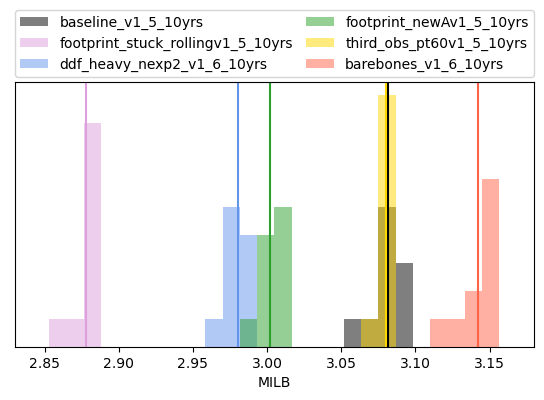

In [11]:
fig,ax = plt.subplots(figsize=(6.7,3.5), dpi=100)

for os, values in all_milb.items():
    # hist of ensemble of MILB
    ax.hist(values, label=os_names[os], 
             bins=30, range=(2.83, 3.18), 
             color=os_colors[os], alpha=0.5)
    # vertical line for mean MILB
    ax.axvline(values.mean(), c=os_colors[os])
    
# legend above plot
ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

# other plot settings
ax.set(xlabel="MILB", xlim=(2.83, 3.18), yticks=[])

# save the figure
fig.savefig("figures/MILB.pdf")